## **Dependencias**

In [77]:
!pip install -q agentpy numpy matplotlib seaborn

## **Imports y estilo**

In [78]:
import agentpy as ap
import numpy as np
import csv
import json
from matplotlib import pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
from IPython.display import HTML
sns.set(context="notebook", style="whitegrid")

## **Parámetros**

In [79]:
def generate_traffic_plan(steps, lamE, lamW, lamS, seed=183):
    np.random.seed(seed)

    plan = []
    for t in range(steps):
        row = {
            "AV1_E": np.random.poisson(lamE),
            "AV1_W": np.random.poisson(lamW),
            "C3_S":  np.random.poisson(lamS)
        }
        plan.append(row)
    return plan

In [80]:
params = {
    'steps': 1000,          # duración en ticks (1 tick = 1 s)

    # Semaforo AV1-C3
    'green_av1': 22,        # VERDE para AV1(E-W)
    'green_c3': 12,        # VERDE para C3(S-N)
    'yellow': 3,           # ÁMBAR
    'all_red': 1,          # ALL-RED (despeje)

    # Tasas Poisson de arribo (veh/s) por aproximación
    'lambda_AV1_E': 0.25,  # autos que entran desde el Este hacia W 0.25
    'lambda_AV1_W': 0.19,  # autos que entran desde el Oesta hacia E 0.19
    'lambda_C3_S': 0.10,   # autos que entran desde el Sur en C3 hacia N 0.10

    # Cinemática
    'v_free': 7.0,         # m/s
    'headway': 8.0,        # m separación mínima

    # Geometría
    'w': 3.5,              # ancho de carril

    # Calles definidas como rutas de puntos
    'roads': {
        'AV1': [(-80, 40), (24, -12), (80, 28)],
        'AV1_E': [(80,29.66),(24,-10.34),(-80,41.82)],
        'AV1_W': [(-80,38.2),(24,-13.81),(80,26.35)],
        'C2':  [(-63.72, 30.06), (-48, -80)],
        'C4':  [(-27.61, 15.62), (-12, 80)],
        'C3':  [(80, -20), (52, 8)]
    },

    # Intersecciones clave para dibujar
    'nodes': {
        'AV1_C2': (-63.72, 30.06),
        'AV1_C4': (-27.61, 15.62),
        'AV1_C3': (52, 8)
    },

    # Puntos de alto aproximados antes del cruce AV1–C3
    'stop_points': {
        'AV1_E': (59, 14.66),     # aproximación desde el Este
        'AV1_W': (45, 1.35),     # aproximación desde el Oeste
        'C3_S':  (58, 2)      # aproximación desde C3
    },

    # Límites para dibujar y simular
    'boundary': {
        'xmin': -80,
        'xmax': 80,
        'ymin': -80,
        'ymax': 80
    },

    # Flag para mostrar el debug
    'debug': False
}
print(params["roads"]["AV1_E"][:2] + params["roads"]["C2"])
print(params["roads"]["AV1_E"][:2] + params["roads"]["C4"])
print(params["roads"]["AV1_W"][:1] + params["roads"]["C2"])
print(params["roads"]["AV1_W"][:1] + params["roads"]["C4"])
print(params["roads"]["C3"] + params["roads"]["AV1_W"][2:])
print(params["roads"]["C3"] + params["roads"]["AV1_E"][1:])
print(params["roads"]["C3"] + params["roads"]["AV1_E"][1:2] + params["roads"]["C4"])


[(80, 29.66), (24, -10.34), (-63.72, 30.06), (-48, -80)]
[(80, 29.66), (24, -10.34), (-27.61, 15.62), (-12, 80)]
[(-80, 38.2), (-63.72, 30.06), (-48, -80)]
[(-80, 38.2), (-27.61, 15.62), (-12, 80)]
[(80, -20), (52, 8), (80, 26.35)]
[(80, -20), (52, 8), (24, -10.34), (-80, 41.82)]
[(80, -20), (52, 8), (24, -10.34), (-27.61, 15.62), (-12, 80)]


In [81]:
traffic_plan = generate_traffic_plan(
    steps=params["steps"],
    lamE=params["lambda_AV1_E"],
    lamW=params["lambda_AV1_W"],
    lamS=params["lambda_C3_S"],
    seed=123  # semilla fija para reproducibilidad
)

params["traffic_plan"] = traffic_plan


## **Controlador Agente Semafórico Fijo**

In [82]:
class SimpleFourWaySignals(ap.Agent):
    """Control alternado: fase NS y fase EW, con subestados G/Y/AR."""

    def setup(self, green_av1, green_c3, yellow, all_red):
        self.g_av1, self.g_c3 = int(green_av1), int(green_c3)
        self.y, self.ar = int(yellow), int(all_red)
        self.phase = 0          # 0 = AV1 verde, 1 = C3 verde
        self.sub = 'G'          # 'G','Y','AR'
        self.t_in = 0

    def lights(self):
        L = {d:'R' for d in ['N','S','E','W']}
        if self.phase == 0:
          # Fase AV1: E y W tienen el subestado
            L['E'] = L['W'] = self.sub
        else:
          # Fase C3: S tiene el subsestado
            L['S'] = self.sub
        return L

    @property
    def green_dirs(self):
        if self.sub != 'G': return set()
        return {'N','S'} if self.phase == 0 else {'E','W'}

    def step(self):
        if self.phase == 0:
          # Fase AV1
            if self.sub == 'G' and self.t_in >= self.g_av1: self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y: self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar: self.phase, self.sub, self.t_in = 1, 'G', 0
            else: self.t_in += 1
        else:
          # Fase C3
            if self.sub == 'G' and self.t_in >= self.g_c3: self.sub, self.t_in = 'Y', 0
            elif self.sub == 'Y' and self.t_in >= self.y: self.sub, self.t_in = 'AR', 0
            elif self.sub == 'AR' and self.t_in >= self.ar: self.phase, self.sub, self.t_in = 0, 'G', 0
            else: self.t_in += 1

## **Controlador Agente Semafórico Inteligente Heurística**

In [83]:
class HeuristicFourWaySignals(SimpleFourWaySignals):
  def setup(self, green_av1, green_c3, yellow, all_red):
    super().setup(green_av1, green_c3, yellow, all_red)
    self.minGreen = 8 # tiempo minimo verde antes de permitir switch
    self.umbral = 2    # diferencia minima para piorizar C3

  def step(self):
    debug = self.model.p.get('debug', False)
    colaE, colaW, colaS = self.model.getQueueLengths()

    # Estado actual del semaforo
    phase = self.phase # 0 = AV1, 1 = C3
    sub = self.sub
    t_in = self.t_in

    if debug:
      print(f"\n[DEBUG][t={self.model.t}] ── Semáforo Inteligente ──")
      print(f"  Fase actual: {'AV1 (E/W)' if phase==0 else 'C3 (S)'}")
      print(f"  Subfase: {sub}   t_in={t_in}")
      print(f"  Colas → E={colaE}, W={colaW}, S={colaS}")

    # Caso 1: si no esta en verde se sigue la logica de transicion normal
    if sub == 'Y':
      if debug:
        print("  Subfase Y → esperando a completar yellow")

      if t_in >= self.y:
        self.sub, self.t_in = 'AR', 0

        if debug:
          print("  -> Cambio: YELLOW → ALL RED (AR)")
      else:
        self.t_in += 1
      return
    if sub == 'AR':
      if debug:
        print("  Subfase AR → despeje")
      if t_in >= self.ar:
        self.phase, self.sub, self.t_in = 1 - self.phase, 'G', 0

        if debug:
          print(f"  -> Cambio: ALL RED → VERDE")
          print(f"  Nueva fase = {'AV1 (E/W)' if self.phase==0 else 'C3 (S)'}")
      else:
        self.t_in += 1
      return

    # Caso 2: si esta en verde se aplica la logica heuristica
    if sub == 'G':
      # No permitir cambio antes del minimo
      if t_in < self.minGreen:
        if debug:
          print(f"  Verde durante {t_in}s (< min_green={self.minGreen}). No se permite cambio aún.")

        self.t_in += 1
        return

      # Heuristica Principal
      # Fase 0 = AV1 y la cola de C3 se esta acumulando
      if phase == 0:
        if debug:
          print("  Evaluando si C3 debe recibir verde...")
        # Si la cola C3 es mayor a la cola maxima de AV1(E/W) mas su umbral
        if colaS > max(colaE, colaW) + self.umbral:
          if debug:
            print(f"  -> Cola S ({colaS}) es mayor que E={colaE}, W={colaW} + umbral={self.umbral}")
            print("  -> Decisión: cambiar fase de AV1 a C3")

          # Cambiar a Amarillo
          self.sub, self.t_in = 'Y', 0
          return

        # Si ya se cumplio el tiempo de verde base
        if t_in >= self.g_av1:
          if debug:
            print(f"  -> Duración verde AV1 cumplida ({t_in}s >= {self.g_av1}s). Cambiando a Y.")
          self.sub, self.t_in = 'Y', 0
          return

      # Fase 1 = C3 y las colas de AV1 se estan acumulando
      else:
        if debug:
          print("  Evaluando si AV1 debe recibir verde...")

        # Si la cola AV1(E/W) es mayor a la cola maxima de C3 mas su umbral
        if max(colaE, colaW) > colaS + self.umbral:
          if debug:
              print(f"  -> Cola AV1 mayor ({max(colaE,colaW)}) que S={colaS} + umbral={self.umbral}")
              print("  -> Decisión: cambiar fase de C3 a AV1")

          # Cambiar a Amarillo
          self.sub, self.t_in = 'Y', 0
          return

        # Si ya se cumplio el tiempo de verde base
        if t_in >= self.g_c3:
          if debug:
            print(f"  -> Duración verde C3 cumplida ({t_in}s >= {self.g_c3}s). Cambiando a Y.")

          self.sub, self.t_in = 'Y', 0
          return

      # Si la heuristica dice continuar verde
      if debug:
        print("  -> Resultado: mantener VERDE")

      self.t_in += 1
      return



## **Iniciar Agente Vehículo**

In [84]:
class Car(ap.Agent):
    """Auto en carril recto: entra desde un borde y atraviesa la intersección si tiene luz verde."""

    def setup(self, origin):
        self.origin = origin            # 'AV1_E','AV1_W','C3_S'
        self.state = 'go'         # 'stop','go','done'
        p = self.model.p

        # Caminos posibles del agente
        roads = p["roads"]

        # Rutas segun el origen
        if origin == 'AV1_E':
            # Aproximacion al semaforo: llega desde E
            self.approach = 'E'

            # Punto de alto
            self.stop_point = np.array(p["stop_points"]["AV1_E"])

            # Decidir ruta aleatoria:
            r = np.random.rand()

            if r < 0.90:
                # Ruta 1: seguir recto hasta salir por W
                pts = roads["AV1_E"]

            elif r < 0.99:
                # Ruta 2: girar en C2 hacia S
                pts = roads["AV1_E"][:2] + roads["C2"]

            else:
                # Ruta 3: girar en C4 hacia N
                pts = roads["AV1_E"][:2] + roads["C4"]

        elif origin == 'AV1_W':
            # Aproximacion al semaforo: viene desde W
            self.approach = 'W'

            # Punto de alto
            self.stop_point = np.array(p["stop_points"]["AV1_W"])

            # Decidir ruta aleatoria
            r = np.random.rand()

            if r < 0.84:
                # Ruta 1: seguir recto hasta salir por E
                pts = roads["AV1_W"]

            elif r < 0.99:
                # Ruta 2: girar en C2 hacia S
                pts = roads["AV1_W"][:1] + roads["C2"]

            else:
                # Ruta 3: girar en C4 hacia N
                pts = roads["AV1_W"][:1] + roads["C4"]

        elif origin == 'C3_S':
            # Aproximacion al semaforo: viene desde S por C3
            self.approach = 'S'

            # Punto de alto
            self.stop_point = np.array(p["stop_points"]["C3_S"])

            # Decidir ruta aleatoria
            r = np.random.rand()

            # Decide si gira hacia E o hacia W en AV1
            if r < 0.65:
                # C3 -> AV1 hacia E
                pts = roads["C3"] + roads["AV1_W"][2:]
            else:
                # C3 -> AV1 hacia W
                # Decidir ruta aleatoria:
                r_inner = np.random.rand()

                if r_inner < 0.99:
                    # Ruta 1: seguir recto hasta salir por W
                    pts = roads["C3"] + roads["AV1_E"][1:]
                else:
                    # Ruta 3: girar en C4 hacia N
                    pts = roads["C3"] + roads["AV1_E"][1:2] + roads["C4"]

        else:
            raise ValueError(f"Origen desconocido: {origin}")

        # Convertir pts a np.array y definir la ruta del agente
        self.route = [np.array(pt, dtype=float) for pt in pts]

        # Posicion inicial = primer punto de la ruta
        self.pos = self.route[0].copy()

        # Objetivo inicial
        self.current_target_index = 1 if len(self.route) > 1 else 0

        # Dirección inicial
        if len(self.route) > 1:
            vec = self.route[1] - self.route[0]
            dist = np.linalg.norm(vec)
            self.dir = vec / dist if dist > 0 else np.array([0.0, 0.0])
        else:
            self.dir = np.array([0.0, 0.0])

    def dist_to(self, p): return np.linalg.norm(self.pos - p)

    def step(self):
        if self.state == 'done': return

        p = self.model.p
        debug = p.get('debug', False)

        # Si ya terminó toda la ruta
        if self.current_target_index >= len(self.route):
            if debug:
                print(f"[t={self.model.t}] Car {self.id} terminó ruta.")
            self.state = 'done'
            return

        # Obtener target dinamico
        target = self.route[self.current_target_index]

        # Direccion dinamica hacia el target
        vec = target - self.pos
        dist = np.linalg.norm(vec)
        next_dir = vec / dist if dist > 0 else self.dir

        if debug:
            print(f"[t={self.model.t}] Car {self.id} | Origin: {self.origin} | Pos: {self.pos} | Target Index: {self.current_target_index} | Next Target: {target} | Current Dir: {self.dir}")

        # Reglas de semaforo en la inter AV1-C3
        # Solo aplica cerca de la inter AV1-C3
        d_stop = np.linalg.norm(self.pos - self.stop_point)
        lights = self.model.ctrl.lights()
        light = lights[self.approach]
        luz_verde = (light == 'G')

        # Si esta a menos de 4m del stop_point pero no se ha pasado aun del punto de parada
        # y la luz NO es verde , se detiene instantáneamente
        if d_stop < 4.0 and not luz_verde and d_stop > 0.0:
            if debug:
                print(f"    -> Car {self.id} DETENIDO por semaforo {light}")
            self.state = 'stop'
            # No actualizar posición, simplemente retornar
            return
        else:
            self.state = 'go'

        # Zona de decisión cerca del target: si el coche está a menos de 4m del objetivo actual
        if dist < 4.0:
            if debug:
                  print(
                      f"    -> Car {self.id} alcanzó target {self.current_target_index} {target}, "
                      f"cambiando dirección a {next_dir}"
                  )
            self.pos = target.copy() # Ajustar la posición al target para mayor precisión
            self.current_target_index += 1 # Avanzar al siguiente objetivo

            # Reevaluar si la ruta ya se acabó después de avanzar el índice
            if self.current_target_index >= len(self.route):
                if debug:
                    print(f"    -> Car {self.id} completó todos los tramos. Done.")
                self.state = 'done'
                return
            # Recalcular next_dir para el nuevo target
            target = self.route[self.current_target_index]
            vec = target - self.pos
            dist = np.linalg.norm(vec)
            next_dir = vec / dist if dist > 0 else self.dir

        vmax = p.v_free
        leader = self.model.headway_ahead(self)

        if leader is not None:
            gap = np.linalg.norm(leader.pos - self.pos)
            if gap < self.model.p.headway:
                vmax = 0.0
                if debug:
                    print(f"    -> Car {self.id} se DETIENE por coche delante.")

        # Avanzar
        self.dir = next_dir
        self.pos = self.pos + self.dir * vmax # dt=1 s

## **Gráficos y Animación**

In [85]:
def road_segment(ax, p0, p1, width, color="#e0e0e0"):
  """Dibuja un segmento de calle entre p0 y p1 como un rectangulo"""
  x0, y0 = p0
  x1, y1 = p1

  # Vector direccion
  dx = x1 - x0
  dy = y1 - y0

  # Longitud de segmento
  length = np.hypot(dx, dy)
  if length == 0:
    return

  # Angulo en grados
  angle = np.degrees(np.arctan2(dy, dx))

  # Rectangulo centrado en p0 y p1 pero partiendo de p0
  rect = plt.Rectangle((x0, y0 - width / 2), length, width, linewidth=1, color=color, zorder=0)

  # Aplicar rectangulo al grafico
  transf = transforms.Affine2D().rotate_deg_around(x0, y0, angle) + ax.transData
  rect.set_transform(transf)
  ax.add_patch(rect)

def draw_intersection(ax, m):

    ax.clear()
    ax.set_xlim(m.p["boundary"]["xmin"], m.p["boundary"]["xmax"])
    ax.set_ylim(m.p["boundary"]["ymin"], m.p["boundary"]["ymax"])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Cruce AV1-C2-C3-C4 | t = {m.t}s")

    roads = m.p["roads"]
    w = m.p["w"]

    # Dibujar cada calle como poligonos de segmentos
    for road, pts in roads.items():
      # Las avenidas AV1_E y AV1_W son ignoradas por ser carriles
      if road in ["AV1_E", "AV1_W"]:
        continue
      # Dibujar C2, C3, C4, y AV1
      for i in range(len(pts) - 1):
        road_segment(ax, pts[i], pts[i+1], width=w*2, color="#e0e0e0")

    # Dibujar las lineas centrales (guias) de cada calle
    for road, pts in roads.items():
      # Las avenidas AV1_E y AV1_W son ignoradas por ser carriles
      if road in ["AV1_E", "AV1_W"]:
        continue
      xs = [pt[0] for pt in pts]
      ys = [pt[1] for pt in pts]
      ax.plot(xs, ys, color="white", lw=1, ls="--", zorder=1)

def my_plot(m, ax):
    draw_intersection(ax, m)

    # Semaforo en la inter AV1-C3
    lights = m.ctrl.lights()
    color_map = {'R':'#d32f2f','Y':'#f9a825','G':'#388e3c', 'AR':'#000000'}

    c_av1_e = color_map[lights['E']]
    ax.add_patch(plt.Circle((55.0, 11.8), 1.0, color=c_av1_e, zorder=3))  # por encima de AV1 en el carril izquierdo
    c_av1_w = color_map[lights['W']]
    ax.add_patch(plt.Circle((49, 4.21), 1.0, color=c_av1_w, zorder=3))  # por encima de AV1 en el carril derecho

    # C3 (S)
    c_c3 = color_map[lights['S']]
    ax.add_patch(plt.Circle((55.0, 5.0), 1.0, color=c_c3, zorder=3))  # debajo de AV1 por el carril central

    # Autos
    if len(m.cars) > 0:
        xs = [c.pos[0] for c in m.cars]
        ys = [c.pos[1] for c in m.cars]
        cs = ['#1976d2' if c.state != 'stop' else '#455a64' for c in m.cars]
        ax.scatter(xs, ys, s=40, c=cs, edgecolor='k', linewidth=0.5, zorder=4)

## **Modelo Simple con Agente Semafórico Fijo**

In [86]:
class SimpleFourWayModel(ap.Model):

    def setup(self):
        p = self.p
        # Controlador semaforico
        self.ctrl = SimpleFourWaySignals(self, p.green_av1, p.green_c3, p.yellow, p.all_red)
        # Lista dinamica de autos
        self.cars = ap.AgentList(self, 0, Car)

        # Buffers para exportacion
        self.vehicle_log = []     # lista de dict
        self.signal_log = []      # lista de dict
        self.queue_log = []       # lista de dict
        self.performance_log = [] # lista de dict

        # Inicializar contadores para métricas
        self.total_spawned_agents = 0
        self.completed_agents = 0
        self.spawned_per_origin = {'AV1_E': 0, 'AV1_W': 0, 'C3_S': 0}

    def headway_ahead(self, me):
        """Líder en el mismo carril y polilineal, si existe. Considerando segmentos consecutivos"""
        same = [c for c in self.cars if c is not me and np.allclose(c.dir, me.dir)]
        if not same: return None
        # candidato delante si el vector a él está en dirección de me.dir y más adelante
        ahead = []
        for c in same:
            v = c.pos - me.pos
            proj = np.dot(v, me.dir)
            if proj > 0:  # adelante
                ahead.append((proj, c))
        if not ahead: return None
        return min(ahead, key=lambda x: x[0])[1]

    def spawn_poisson(self, origin, lam):
        k = np.random.poisson(lam)
        for _ in range(k):
            self.cars.append(Car(self, origin=origin))
            self.total_spawned_agents += 1 # Incrementar el contador de agentes desplegados
            self.spawned_per_origin[origin] += 1 # Incrementar el contador por origen

    def spawn_from_plan(self, plan):
        row = plan[self.t-1]  # diccionario del tick actual

        for origin, count in row.items():
            for _ in range(count):
                self.cars.append(Car(self, origin=origin))
                self.total_spawned_agents += 1
                self.spawned_per_origin[origin] += 1


    def step(self):
        # 1) Arribos solo en los origenes permitidos
        self.spawn_from_plan(self.p.traffic_plan)

        # 2) Actualizar semaforo
        self.ctrl.step()

        # 3) Registrar estado del semaforo para exportacion
        lights = self.ctrl.lights() # contiene {'N', 'S', 'E', 'W'}
        self.signal_log.append({
            "t": self.t,
            "id_sem": "AV1_C3",
            "phase": self.ctrl.sub, # G / Y / AR
            "approach": "AV1_EW" if self.ctrl.phase == 0 else "C3_S"
        })

        # 4) Actualizar vehiculos
        self.cars.step()

        # 5) Registrar posiciones de autos para exportacion
        for c in self.cars:
          self.vehicle_log.append({
              "t": self.t,
              "id": c.id,
              "x": float(c.pos[0]),
              "y": float(c.pos[1]),
              "dir": (float(c.dir[0]), float(c.dir[1])),
              "state": c.state
          })

        # 6) Eliminar los que ya terminaron y actualizar el contador de completados
        # Contar agentes completados antes de filtrarlos
        newly_completed = sum(1 for c in self.cars if c.state == 'done')
        self.completed_agents += newly_completed

        self.cars = ap.AgentList(self, [c for c in self.cars if c.state != 'done'], Car)

        # 7) Registrar colas de autos en el cruce semaforico
        colaE, colaW, colaS = self.getQueueLengths()
        self.queue_log.append({
            "t": self.t,
            "colaE": colaE,
            "colaW": colaW,
            "colaS": colaS,
            "total": colaE + colaW + colaS
        })

        # 8) Registrar desempeno general del modelo
        if self.total_spawned_agents > 0:
          completion_rate = (self.completed_agents / self.total_spawned_agents) * 100
        else:
          completion_rate = 0.0

        self.performance_log.append({
            "t": self.t,
            "spawned": self.total_spawned_agents,
            "completed": self.completed_agents,
            "completion_rate": completion_rate
        })

        # 9) Mostrar métricas de debug (OPCIONAL)
        if self.p.get('debug', True):
            print(f"[t={self.t}] --- Model Metrics ---")
            print(f"[t={self.t}] Total agentes desplegados: {self.total_spawned_agents}")
            print(f"[t={self.t}] Agentes completados: {self.completed_agents}")
            if self.total_spawned_agents > 0:
                completion_rate = (self.completed_agents / self.total_spawned_agents) * 100
                print(f"[t={self.t}] Tasa de finalización: {completion_rate:.2f}%")
            else:
                print(f"[t={self.t}] Tasa de finalización: N/A (no se han desplegado agentes)")
            print(f"[t={self.t}] Agentes desplegados por origen: {self.spawned_per_origin}")

    def getQueueLengths(self):
        """Regresa longitudes aproximadas de colas por acercamiento (E, W, S)"""
        # Inicializar colas
        colaE = 0
        colaW = 0
        colaS = 0

        # Umbral de distancia para considerar que esta 'en fila'
        threshold = 25.0

        for c in self.cars:
          # Distancia al punto de alto propio del agente vehiculo
          d = np.linalg.norm(c.pos - c.stop_point)

          # Agregarlo a la cola correspondiente si esta dentro del treshold
          if c.approach == 'E' and d < threshold:
            colaE += 1
          elif c.approach == 'W' and d < threshold:
            colaW += 1
          elif c.approach == 'S' and d < threshold:
            colaS += 1

        # Devolver el tamano de cada cola
        return colaE, colaW, colaS

    def export_vehicle_csv(self, filename="vehicles_positions.csv"):
      keys = ["t", "id", "x", "y", "dir", "state"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.vehicle_log:
              writer.writerow(row)

    def export_signal_csv(self, filename="signal_timeline.csv"):
      keys = ["t", "id_sem", "phase", "approach"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.signal_log:
              writer.writerow(row)

    def export_queue_csv(self, filename="queue_timeline.csv"):
      keys = ["t", "colaE", "colaW", "colaS", "total"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.queue_log:
              writer.writerow(row)

    def export_performance_csv(self, filename="performance_timeline.csv"):
        keys = ["t", "spawned", "completed", "completion_rate"]
        with open(filename, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=keys)
            writer.writeheader()
            for row in self.performance_log:
                writer.writerow(row)

## **Controlador Agente Semafórico con Q-Learning**


In [88]:
class QLearningFourWaySignals(SimpleFourWaySignals):
  def setup(self, green_av1, green_c3, yellow, all_red):
    super().setup(green_av1, green_c3, yellow, all_red)

    # Parámetros "físicos" del semáforo
    self.minGreen = 8   # tiempo mínimo en verde antes de poder decidir cambiar

    # Parámetros de Q-learning
    self.alpha   = 0.3   # tasa de aprendizaje
    self.gamma   = 0.9   # factor de descuento
    self.epsilon = 0.2   # prob. de explorar (ε-greedy)

    # Q-table: dict { state: [Q_extend, Q_switch] }
    self.q_table = {}

    # Para recordar la decisión anterior (s, a)
    self.last_state  = None
    self.last_action = None

    # Modo entrenamiento (True = aprende, False = política greedy)
    self.training = True

    # Variables nuevas para la recompensa mejorada
    self.wait_AV1 = 0     # Cuantos ticks lleva AV1 esperando rojo
    self.switch_cost = 0  # Penalizacion por cambiar antes de tiempo

  #  Representación de estado
  def get_state(self, colaE, colaW, colaS):
    """
    Representación mejorada del estado:
      - phase: 0 = AV1 verde, 1 = C3 verde
      - cola_av1_bin: bin de congestión para AV1  (0–3)
      - cola_c3_bin:  bin de congestión para C3   (0–3)
      - wait_bin:     bin de espera para AV1      (0–3)
    """

    cola_av1 = colaE + colaW

    # Discretización más fina por niveles
    cola_av1_bin = min(cola_av1 // 5, 3)   # 0 = [0–4], 1 = [5–9], 2 = [10–14], 3 = 15+
    cola_c3_bin  = min(colaS // 5, 3)

    wait_bin = min(self.wait_AV1 // 5, 3)

    # Nuevo estado con más sensibilidad
    return (self.phase, cola_av1_bin, cola_c3_bin, wait_bin)

  def _ensure_state_in_q(self, state):
    """Inicializa Q(s,·) en 0 si el estado no ha sido visto antes."""
    if state not in self.q_table:
      # Dos acciones posibles:
      # 0 = extend (mantener verde)
      # 1 = switch (cambiar fase)
      self.q_table[state] = [0.0, 0.0]

  def choose_action(self, state):
    """
    Devuelve una acción usando política ε-greedy.
    0 = extend (mantener verde)
    1 = switch (cambiar fase)
    """
    self._ensure_state_in_q(state)

    import random
    if self.training and random.random() < self.epsilon:
      # Explorar: acción aleatoria
      return random.randint(0, 1)
    else:
      # Explotar: acción con mejor Q(s,a)
      q_values = self.q_table[state]
      # argmax sencillo
      return 0 if q_values[0] >= q_values[1] else 1

  def update_q(self, prev_state, action, reward, new_state):
    """Actualiza la Q-table con la regla de Q-learning."""
    self._ensure_state_in_q(prev_state)
    self._ensure_state_in_q(new_state)

    q_values_prev = self.q_table[prev_state]
    q_sa = q_values_prev[action]

    max_next = max(self.q_table[new_state])

    # Regla Q-Learning
    # Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
    td_target = reward + self.gamma * max_next
    td_error  = td_target - q_sa

    q_values_prev[action] = q_sa + self.alpha * td_error

  #  Dinámica del semáforo
  def step(self):
    debug = self.model.p.get('debug', False)

    colaE, colaW, colaS = self.model.getQueueLengths()
    cola_av1 = colaE + colaW

    # Estado actual del semáforo
    phase = self.phase  # 0 = AV1, 1 = C3
    sub   = self.sub
    t_in  = self.t_in

    # Actualizar memoria de espera de AV1
    if self.phase != 0:
      self.wait_AV1 += 1
    else:
      self.wait_AV1 = 0

    # Estado discretizado para Q-learning
    current_state = self.get_state(colaE, colaW, colaS)

    if debug:
      print(f"\n[DEBUG][t={self.model.t}] ── Semáforo Q-learning ──")
      print(f"  Fase actual: {'AV1 (E/W)' if phase==0 else 'C3 (S)'}")
      print(f"  Subfase: {sub}   t_in={t_in}")
      print(f"  Colas → E={colaE}, W={colaW}, S={colaS}")
      print(f"  Estado RL: {current_state}")

    # 1) Actualizar Q(s,a) de la decisión anterior (si existe)
    if self.last_state is not None and self.last_action is not None:
      # Recompensa con priorizacion de AV1
      reward = - (
          2.1 * cola_av1 +        # AV1 pesa mas
          1.6 * colaS +           # C3 pesa menos
          0.4 * self.wait_AV1 +   # Castigo por hacer esperar AV1
          0.1 * self.switch_cost  # Castigo por cambio prematuro
      )

      # Penalizacion adicional si se mantiene verde en C3 cuando AV1 esta cargado
      if self.phase == 1 and cola_av1 > colaS:
        reward -= 8

      if debug:
        print(f"  [RL] reward={reward}")

      self.update_q(self.last_state, self.last_action, reward, current_state)
      # Limpiamos para no actualizar múltiples veces por la misma acción
      self.last_state  = None
      self.last_action = None

    # 2) Lógica de transición fija para YELLOW (Y) y ALL RED (AR)
    if sub == 'Y':
      if debug:
        print("  Subfase Y → esperando a completar yellow")

      if t_in >= self.y:
        # Pasamos a ALL RED (AR)
        self.sub, self.t_in = 'AR', 0
        if debug:
          print("  -> Cambio: YELLOW → ALL RED (AR)")
      else:
        self.t_in += 1
      return

    if sub == 'AR':
      if debug:
        print("  Subfase AR → despeje")

      if t_in >= self.ar:
        # Elegir mejor fase (ya no alternar solo entre 0 <-> 1)
        if cola_av1 > colaS:
          self.phase = 0
        else:
          self.phase = 1

        self.sub, self.t_in = 'G', 0
      else:
        self.t_in += 1
      return

    # 3) Lógica de control en VERDE (sub == 'G') con Q-learning
    if sub == 'G':
      # Primero: respetar un mínimo de verde antes de tomar decisiones RL
      if t_in < self.minGreen:
        if debug:
          print(f"  Verde durante {t_in}s (< minGreen={self.minGreen}). "
                "RL aún no puede decidir, se mantiene verde.")
        self.t_in += 1
        return

      # Aquí ya podemos dejar que Q-learning decida:
      action = self.choose_action(current_state)
      if debug:
        accion_txt = "EXTEND (mantener verde)" if action == 0 else "SWITCH (cambiar fase)"
        print(f"  [RL] Acción elegida: {accion_txt}  (estado={current_state})")

      # Guardamos esta decisión para actualizar Q en el futuro
      self.last_state  = current_state
      self.last_action = action

      # Evaluar si switch es prematuro
      if action == 1 and self.t_in < self.minGreen + 4:
        self.switch_cost = 5
      else:
        self.switch_cost = 0

      if action == 0:
        # EXTEND: mantener verde en la fase actual
        if debug:
          print("  -> Decisión RL: mantener VERDE en fase actual")
        self.t_in += 1
        return
      else:
        # SWITCH: iniciar ciclo de cambio → pasar a AMARILLO
        if debug:
          print("  -> Decisión RL: iniciar cambio de fase (G → Y)")
        self.sub, self.t_in = 'Y', 0
        return

## **Modelo Inteligente con Agente Semafórico con Q-Learning**

### Definicion del Modelo

In [89]:
class QLearningFourWayModel(ap.Model):

    def setup(self):
        p = self.p
        # Controlador semaforico
        self.ctrl = QLearningFourWaySignals(self, p.green_av1, p.green_c3, p.yellow, p.all_red)
        # Lista dinamica de autos
        self.cars = ap.AgentList(self, 0, Car)

        # Buffers para exportacion
        self.vehicle_log = []     # lista de dict
        self.signal_log = []      # lista de dict
        self.queue_log = []       # lista de dict
        self.performance_log = [] # lista de dict

        # Inicializar contadores para métricas
        self.total_spawned_agents = 0
        self.completed_agents = 0
        self.spawned_per_origin = {'AV1_E': 0, 'AV1_W': 0, 'C3_S': 0}

    def headway_ahead(self, me):
        """Líder en el mismo carril y polilineal, si existe. Considerando segmentos consecutivos"""
        same = [c for c in self.cars if c is not me and np.allclose(c.dir, me.dir)]
        if not same: return None
        # candidato delante si el vector a él está en dirección de me.dir y más adelante
        ahead = []
        for c in same:
            v = c.pos - me.pos
            proj = np.dot(v, me.dir)
            if proj > 0:  # adelante
                ahead.append((proj, c))
        if not ahead: return None
        return min(ahead, key=lambda x: x[0])[1]

    def spawn_poisson(self, origin, lam):
        k = np.random.poisson(lam)
        for _ in range(k):
            self.cars.append(Car(self, origin=origin))
            self.total_spawned_agents += 1 # Incrementar el contador de agentes desplegados
            self.spawned_per_origin[origin] += 1 # Incrementar el contador por origen

    def spawn_from_plan(self, plan):
        row = plan[self.t - 1]  # diccionario del tick actual, corregido a self.t - 1

        for origin, count in row.items():
            for _ in range(count):
                self.cars.append(Car(self, origin=origin))
                self.total_spawned_agents += 1
                self.spawned_per_origin[origin] += 1


    def step(self):
        # 1) Arribos solo en los origenes permitidos
        self.spawn_from_plan(self.p.traffic_plan)

        # 2) Actualizar semaforo
        self.ctrl.step()

        # 3) Registrar estado del semaforo para exportacion
        lights = self.ctrl.lights() # contiene {'N', 'S', 'E', 'W'}
        self.signal_log.append({
            "t": self.t,
            "id_sem": "AV1_C3",
            "phase": self.ctrl.sub, # G / Y / AR
            "approach": "AV1_EW" if self.ctrl.phase == 0 else "C3_S"
        })

        # 4) Actualizar vehiculos
        self.cars.step()

        # 5) Registrar posiciones de autos para exportacion
        for c in self.cars:
          self.vehicle_log.append({
              "t": self.t,
              "id": c.id,
              "x": float(c.pos[0]),
              "y": float(c.pos[1]),
              "dir": (float(c.dir[0]), float(c.dir[1])),
              "state": c.state
          })

        # 6) Eliminar los que ya terminaron y actualizar el contador de completados
        # Contar agentes completados antes de filtrarlos
        newly_completed = sum(1 for c in self.cars if c.state == 'done')
        self.completed_agents += newly_completed

        self.cars = ap.AgentList(self, [c for c in self.cars if c.state != 'done'], Car)

        # 7) Registrar colas de autos en el cruce semaforico
        colaE, colaW, colaS = self.getQueueLengths()
        self.queue_log.append({
            "t": self.t,
            "colaE": colaE,
            "colaW": colaW,
            "colaS": colaS,
            "total": colaE + colaW + colaS
        })

        # 8) Registrar desempeno general del modelo
        if self.total_spawned_agents > 0:
          completion_rate = (self.completed_agents / self.total_spawned_agents) * 100
        else:
          completion_rate = 0.0

        self.performance_log.append({
            "t": self.t,
            "spawned": self.total_spawned_agents,
            "completed": self.completed_agents,
            "completion_rate": completion_rate
        })

        # 9) Mostrar métricas de debug (OPCIONAL)
        if self.p.get('debug', True):
            print(f"[t={self.t}] --- Model Metrics ---")
            print(f"[t={self.t}] Total agentes desplegados: {self.total_spawned_agents}")
            print(f"[t={self.t}] Agentes completados: {self.completed_agents}")
            if self.total_spawned_agents > 0:
                completion_rate = (self.completed_agents / self.total_spawned_agents) * 100
                print(f"[t={self.t}] Tasa de finalización: {completion_rate:.2f}%")
            else:
                print(f"[t={self.t}] Tasa de finalización: N/A (no se han desplegado agentes)")
            print(f"[t={self.t}] Agentes desplegados por origen: {self.spawned_per_origin}")

    def getQueueLengths(self):
        """Regresa longitudes aproximadas de colas por acercamiento (E, W, S)"""
        # Inicializar colas
        colaE = 0
        colaW = 0
        colaS = 0

        # Umbral de distancia para considerar que esta 'en fila'
        threshold = 25.0

        for c in self.cars:
          # Distancia al punto de alto propio del agente vehiculo
          d = np.linalg.norm(c.pos - c.stop_point)

          # Agregarlo a la cola correspondiente si esta dentro del treshold
          if c.approach == 'E' and d < threshold:
            colaE += 1
          elif c.approach == 'W' and d < threshold:
            colaW += 1
          elif c.approach == 'S' and d < threshold:
            colaS += 1

        # Devolver el tamano de cada cola
        return colaE, colaW, colaS

    def export_vehicle_csv(self, filename="vehicles_positions.csv"):
      keys = ["t", "id", "x", "y", "dir", "state"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.vehicle_log:
              writer.writerow(row)

    def export_signal_csv(self, filename="signal_timeline.csv"):
      keys = ["t", "id_sem", "phase", "approach"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.signal_log:
              writer.writerow(row)

    def export_queue_csv(self, filename="queue_timeline.csv"):
      keys = ["t", "colaE", "colaW", "colaS", "total"]
      with open(filename, "w", newline="") as f:
          writer = csv.DictWriter(f, fieldnames=keys)
          writer.writeheader()
          for row in self.queue_log:
              writer.writerow(row)

    def export_performance_csv(self, filename="performance_timeline.csv"):
        keys = ["t", "spawned", "completed", "completion_rate"]
        with open(filename, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=keys)
            writer.writeheader()
            for row in self.performance_log:
                writer.writerow(row)

### Ejecucion del Modelo Avanzado

In [134]:
# ========= 1) Modelo para obtener datos =========
simple_model_data = SimpleFourWayModel(params)
simple_results = simple_model_data.run()

simple_model_data.export_vehicle_csv("simple_vehicles_positions.csv")
simple_model_data.export_signal_csv("simple_signal_timeline.csv")
simple_model_data.export_queue_csv("simple_queue_timeline.csv")
simple_model_data.export_performance_csv("simple_performance_timeline.csv")


""" ========= 2) Modelo nuevo para animación =========
fig, ax = plt.subplots(figsize=(6,6))
simple_model_anim = SimpleFourWayModel(params)

simple_anim = ap.animate(simple_model_anim, fig, ax, my_plot)
HTML(simple_anim.to_jshtml())"""

Completed: 1000 steps
Run time: 0:00:11.896463
Simulation finished


' ========= 2) Modelo nuevo para animación =========\nfig, ax = plt.subplots(figsize=(6,6))\nsimple_model_anim = SimpleFourWayModel(params)\n\nsimple_anim = ap.animate(simple_model_anim, fig, ax, my_plot)\nHTML(simple_anim.to_jshtml())'

In [135]:
# ========= 1) Modelo para obtener datos =========
advanced_model_data = QLearningFourWayModel(params)
advanced_results = advanced_model_data.run()

advanced_model_data.export_vehicle_csv("advanced_vehicles_positions.csv")
advanced_model_data.export_signal_csv("advanced_signal_timeline.csv")
advanced_model_data.export_queue_csv("advanced_queue_timeline.csv")
advanced_model_data.export_performance_csv("advanced_performance_timeline.csv")


"""# ========= 2) Modelo nuevo para animación =========
fig1, ax1 = plt.subplots(figsize=(6,6))
advanced_model_anim = QLearningFourWayModel(params)

advanced_anim = ap.animate(advanced_model_anim, fig1, ax1, my_plot)
HTML(advanced_anim.to_jshtml())"""

Completed: 1000 steps
Run time: 0:00:09.360061
Simulation finished


'# ========= 2) Modelo nuevo para animación =========\nfig1, ax1 = plt.subplots(figsize=(6,6))\nadvanced_model_anim = QLearningFourWayModel(params)\n\nadvanced_anim = ap.animate(advanced_model_anim, fig1, ax1, my_plot)\nHTML(advanced_anim.to_jshtml())'

## **Graficas de Metricas**

In [136]:
import pandas as pd

# Cargar datos desde los archivos .csv
simple_q = pd.read_csv("simple_queue_timeline.csv")
advanced_q = pd.read_csv("advanced_queue_timeline.csv")

simple_perf = pd.read_csv("simple_performance_timeline.csv")
advanced_perf = pd.read_csv("advanced_performance_timeline.csv")

# --- METRICAS DE COLA ---
metrics = ["colaE", "colaW", "colaS", "total"]

print("\n===== MEJORA PROMEDIO EN COLAS (Q-learning vs Simple) =====")

for m in metrics:
    simple_avg = simple_q[m].mean()
    advanced_avg = advanced_q[m].mean()
    improvement = (simple_avg - advanced_avg) / simple_avg * 100
    print(f"{m}: {improvement:.2f}%")

# --- METRICAS DE COMPLETION RATE ---
print("\n===== MEJORA EN COMPLETION RATE =====")

simple_cr = simple_perf["completion_rate"].mean()
advanced_cr = advanced_perf["completion_rate"].mean()

improvement_cr = (advanced_cr - simple_cr) / simple_cr * 100
print(f"Completion rate: {improvement_cr:.2f}%")

# --- THROUGHPUT (completed / spawned) ----
print("\n===== MEJORA EN THROUGHPUT =====")

simple_final_thr = simple_perf["completed"].iloc[-1] / simple_perf["spawned"].iloc[-1]
advanced_final_thr = advanced_perf["completed"].iloc[-1] / advanced_perf["spawned"].iloc[-1]

improvement_thr = (advanced_final_thr - simple_final_thr) / simple_final_thr * 100
print(f"Throughput final: {improvement_thr:.2f}%")


===== MEJORA PROMEDIO EN COLAS (Q-learning vs Simple) =====
colaE: 7.66%
colaW: 34.62%
colaS: -6.54%
total: 13.96%

===== MEJORA EN COMPLETION RATE =====
Completion rate: 1.71%

===== MEJORA EN THROUGHPUT =====
Throughput final: 0.38%


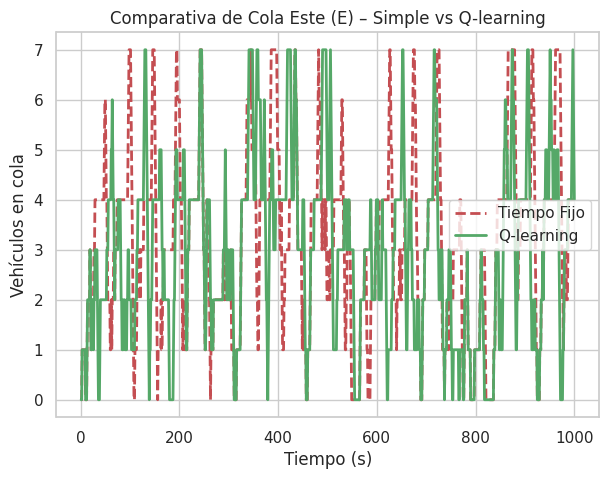

In [137]:
plt.figure(figsize=(7,5))
plt.plot(simple_q["t"], simple_q["colaE"], 'r--', label="Tiempo Fijo", linewidth=2)
plt.plot(advanced_q["t"], advanced_q["colaE"], 'g-', label="Q-learning", linewidth=2)

plt.xlabel("Tiempo (s)")
plt.ylabel("Vehículos en cola")
plt.title("Comparativa de Cola Este (E) – Simple vs Q-learning")
plt.legend()
plt.grid(True)
plt.savefig('comparativa_cola_este.png')
plt.show()


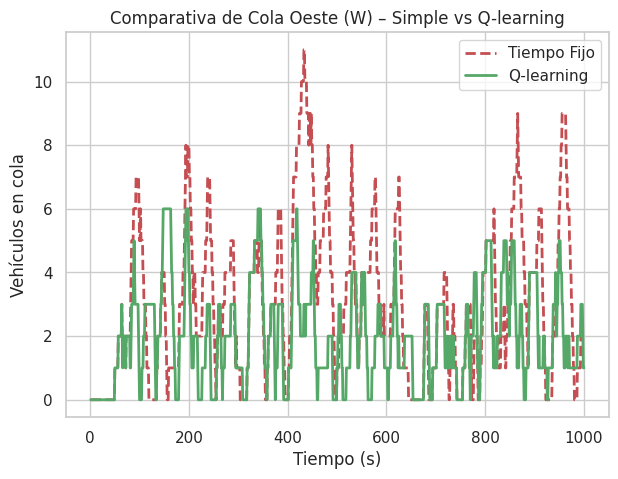

In [138]:
plt.figure(figsize=(7,5))
plt.plot(simple_q["t"], simple_q["colaW"], 'r--', label="Tiempo Fijo", linewidth=2)
plt.plot(advanced_q["t"], advanced_q["colaW"], 'g-', label="Q-learning", linewidth=2)

plt.xlabel("Tiempo (s)")
plt.ylabel("Vehículos en cola")
plt.title("Comparativa de Cola Oeste (W) – Simple vs Q-learning")
plt.legend()
plt.grid(True)
plt.savefig('comparativa_cola_oeste.png')
plt.show()


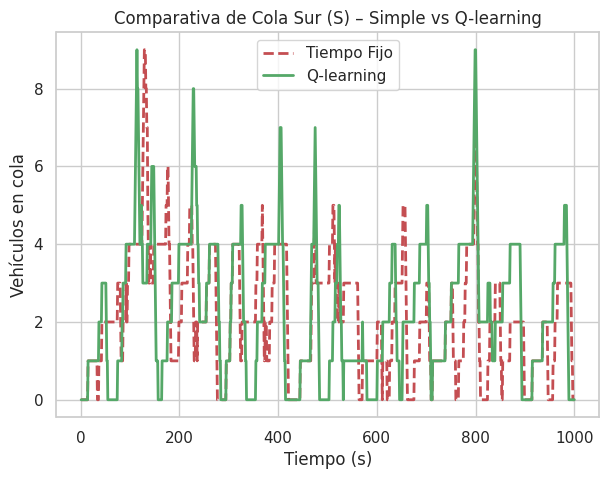

In [139]:
plt.figure(figsize=(7,5))
plt.plot(simple_q["t"], simple_q["colaS"], 'r--', label="Tiempo Fijo", linewidth=2)
plt.plot(advanced_q["t"], advanced_q["colaS"], 'g-', label="Q-learning", linewidth=2)

plt.xlabel("Tiempo (s)")
plt.ylabel("Vehículos en cola")
plt.title("Comparativa de Cola Sur (S) – Simple vs Q-learning")
plt.legend()
plt.grid(True)
plt.savefig('comparativa_cola_sur.png')
plt.show()


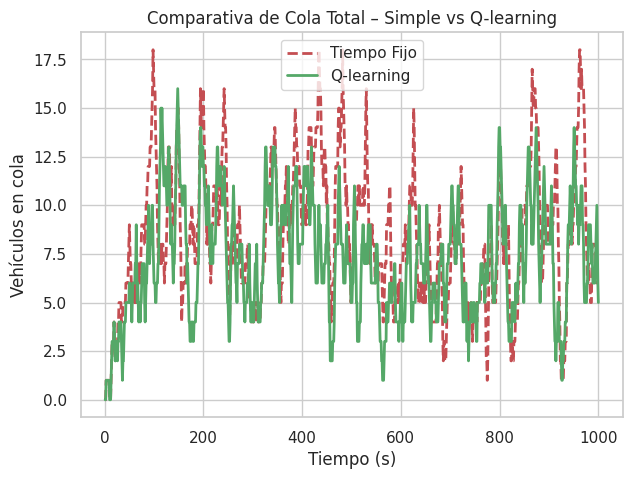

In [140]:
plt.figure(figsize=(7,5))
plt.plot(simple_q["t"], simple_q["total"], 'r--', label="Tiempo Fijo", linewidth=2)
plt.plot(advanced_q["t"], advanced_q["total"], 'g-', label="Q-learning", linewidth=2)

plt.xlabel("Tiempo (s)")
plt.ylabel("Vehículos en cola")
plt.title("Comparativa de Cola Total – Simple vs Q-learning")
plt.legend()
plt.grid(True)
plt.savefig('comparativa_cola_total.png')
plt.show()


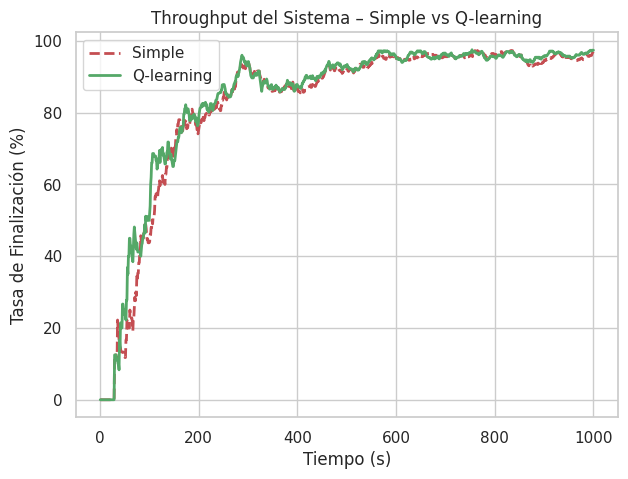

In [141]:
plt.figure(figsize=(7,5))
plt.plot(simple_perf["t"], simple_perf["completion_rate"], 'r--', label="Simple", linewidth=2)
plt.plot(advanced_perf["t"], advanced_perf["completion_rate"], 'g-', label="Q-learning", linewidth=2)

plt.xlabel("Tiempo (s)")
plt.ylabel("Tasa de Finalización (%)")
plt.title("Throughput del Sistema – Simple vs Q-learning")
plt.legend()
plt.grid(True)
plt.savefig('comparativa_throuhput.png')
plt.show()


# Reporte Final


> **Nota**: Si dentro del diccionario "params" se define **debug** como True se pueden visualizar las métricas del MAS.